In [32]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from tabulate import tabulate

mpl.style.use("fivethirtyeight")

## Helper functions

In [135]:
def reset_seed(func):
    def wrapper(*args, **kwargs):
        np.random.seed(0)
        return func(*args, **kwargs)
    return wrapper

def _bootstrap(func, n_resamples, samples):
    indices = np.random.choice(samples.shape[0], size=(n_resamples, samples.shape[0]), replace=True)
    return np.array([func(samples[i]) for i in indices])

@reset_seed
def bootstrap(func, n_resamples, samples):
    """Use the bootstrap to compute a test statistic many times.
    
    Parameters
    ----------
    func
        A statistic
    samples
        Samples which imply an empirical distribution to resample from
    n_resamples
        Number of times to resample

    Returns
    -------
    A vector of size ``n_resamples``
    """
    return _bootstrap(func, n_resamples, samples)

def make_bootstrap_normal_interval(stat, bootstrap_stats, confidence):
    """Compute a bootstrap normal interval.
    
    Let ``X`` denote the random vector used as input to the statistic ``T(X)``.
    Since we estimate the expectation of ``T(X)`` using a single draw ``T(x)``,
    it follows that the standard error of the mean is ``Std(T(X)) / sqrt(1)``.
    This function returns the normal interval ``T(x) ± z(alpha / 2) * Std(T(X))``
    where ``z(alpha / 2)`` is the appropriate z-statistic.
    """
    se = bootstrap_stats.std()
    return scipy.stats.norm.interval(confidence, loc=stat, scale=se)

def make_bootstrap_pivotal_interval(stat, bootstrap_stats, confidence):
    """Compute a bootstrap pivotal interval."""
    α = 1. - confidence
    a = 2. * stat - np.quantile(bootstrap_stats, 1. - α / 2.)
    b = 2. * stat - np.quantile(bootstrap_stats, α / 2.)
    return (a, b)

def make_bootstrap_percentile_interval(stat, bootstrap_stats, confidence):
    """Compute a bootstrap percentile interval."""
    del stat
    α = 1. - confidence
    a = np.quantile(bootstrap_stats, α / 2.)
    b = np.quantile(bootstrap_stats, 1. - α / 2.)
    return (a, b)

def make_ci_table(bootstrap_stats, confidence, stat):
    args = (stat, bootstrap_stats, confidence)
    normal_interval = make_bootstrap_normal_interval(*args)
    pivotal_interval = make_bootstrap_pivotal_interval(*args)
    percentile_interval = make_bootstrap_percentile_interval(*args)
    return tabulate([
        ("Normal", ) + normal_interval,
        ("Pivotal", ) + pivotal_interval,
        ("Percentile", ) + percentile_interval,
    ], headers=("Interval type", "Lower bound", "Upper bound"), tablefmt="html")

def make_coverage_table(
    confidence,
    exact,
    sample_func,
    stat_func,
    n_experiments,
    n_resamples,
):
    @reset_seed
    def get_interval_stats(interval_func):
        intervals = np.empty([n_experiments, 2])
        for i in range(n_experiments):
            samples = sample_func()
            bootstrap_stats = _bootstrap(stat_func, n_resamples, samples)
            interval = interval_func(stat, bootstrap_stats, confidence)
            intervals[i] = interval
        count = np.sum((intervals[:, 0] <= exact) & (exact <= intervals[:, 1]))
        delta = intervals[:, 1] - intervals[:, 0]
        return (count.item() / n_experiments, delta.mean().item())
        
    return tabulate([
        ("Normal", ) + get_interval_stats(make_bootstrap_normal_interval),
        ("Pivotal", ) + get_interval_stats(make_bootstrap_pivotal_interval),
        ("Percentile", ) + get_interval_stats(make_bootstrap_percentile_interval),
    ], headers=("Interval type", "Coverage probability", "Mean length"), tablefmt="html")

## 1.

'<table>\n<thead>\n<tr><th>Interval type  </th><th style="text-align: right;">  Lower bound</th><th style="text-align: right;">  Upper bound</th></tr>\n</thead>\n<tbody>\n<tr><td>Normal         </td><td style="text-align: right;">     0.166307</td><td style="text-align: right;">     0.925531</td></tr>\n<tr><td>Pivotal        </td><td style="text-align: right;">     0.165015</td><td style="text-align: right;">     0.87692 </td></tr>\n<tr><td>Percentile     </td><td style="text-align: right;">     0.214918</td><td style="text-align: right;">     0.926823</td></tr>\n</tbody>\n</table>'

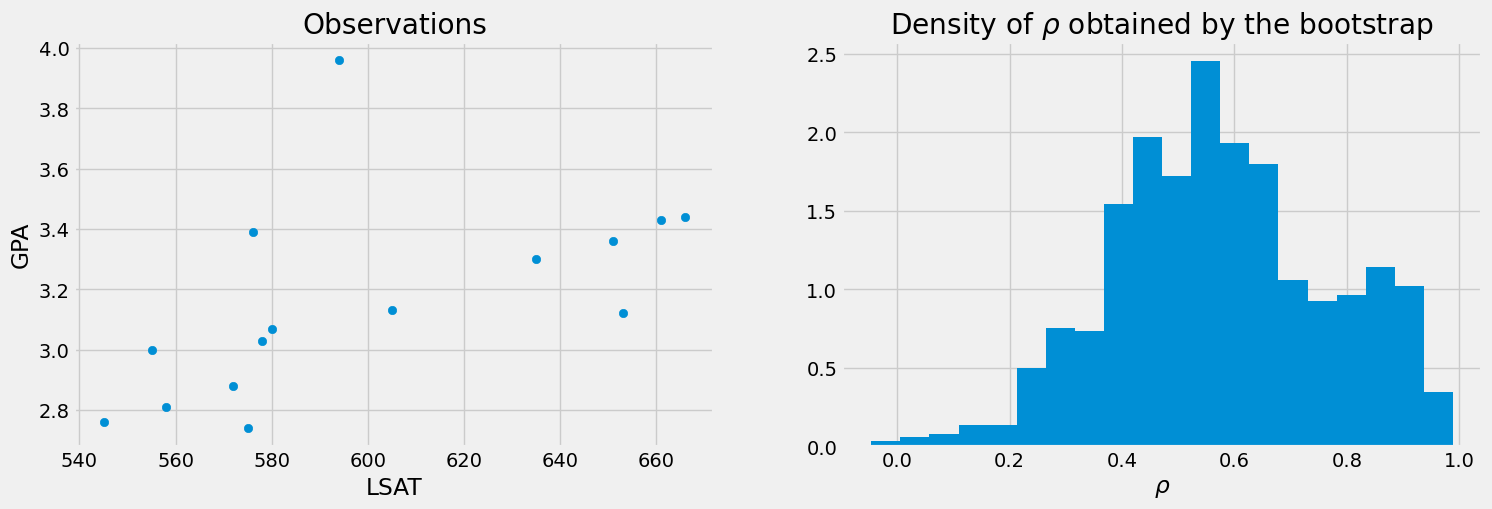

In [85]:
Y = np.array([576 , 635 , 558 , 578 , 666 , 580 , 555 , 661 , 651 , 605 , 653 , 575 , 545 , 572 , 594 ])
Z = np.array([3.39, 3.30, 2.81, 3.03, 3.44, 3.07, 3.00, 3.43, 3.36, 3.13, 3.12, 2.74, 2.76, 2.88, 3.96])

X = np.stack((Y, Z)).T
func = lambda X: np.corrcoef(X[:, 0], X[:, 1])[0, 1]
stat = func(X)
bootstrap_stats = bootstrap(func=func, n_resamples=1_000, samples=X)

_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(1.618*2.*5., 5.))
ax1.scatter(Y, Z)
ax1.set_xlabel("LSAT")
ax1.set_ylabel("GPA")
ax1.set_title("Observations")
ax2.hist(bootstrap_stats, bins=20, density=True)
ax2.set_xlabel(r"$\rho$")
ax2.set_title(r"Density of $\rho$ obtained by the bootstrap")

make_ci_table(bootstrap_stats=bootstrap_stats, confidence=0.95, stat=stat)

## 2.

Completing the square,

$$
\mathbb{E}\left[X^{k}\right]=\mathbb{E}e^{kY}=\int_{-\infty}^{\infty}\frac{1}{\sqrt{2\pi}}e^{-\left(y^{2}-2ky\right)/2}dy=e^{k^{2}/2}.
$$

It follows that $\mathbb{E}X=e^{1/2}$ and $\mathbb{V}X=e^{2}-e=e(e-1)$.

In [140]:
μ = np.exp(0.5)
σ = np.sqrt(np.exp(1.) * (np.exp(1.) - 1.))
make_coverage_table(
    confidence=0.95,
    exact=(-μ**3 + np.exp(4.5) - 3. * μ * np.exp(2.) + 3. * μ**2 * np.exp(0.5)) / σ**3,
    sample_func=lambda: np.exp(np.random.randn(50)),
    stat_func=lambda X: ((X - μ)**3 / σ**3).mean(),
    n_experiments=100,
    n_resamples=100,
)

'<table>\n<thead>\n<tr><th>Interval type  </th><th style="text-align: right;">  Coverage probability</th><th style="text-align: right;">  Mean length</th></tr>\n</thead>\n<tbody>\n<tr><td>Normal         </td><td style="text-align: right;">                   0.3</td><td style="text-align: right;">      15.0168</td></tr>\n<tr><td>Pivotal        </td><td style="text-align: right;">                   0  </td><td style="text-align: right;">      12.3829</td></tr>\n<tr><td>Percentile     </td><td style="text-align: right;">                   0.4</td><td style="text-align: right;">      12.3829</td></tr>\n</tbody>\n</table>'

## 3.

In [143]:
make_coverage_table(
    confidence=0.95,
    exact=(scipy.stats.t(df=3).ppf(0.75) - scipy.stats.t(df=3).ppf(0.25)) / 1.34,
    sample_func=lambda: np.random.standard_t(df=3, size=(25, )),
    stat_func=lambda X: (np.quantile(X, 0.75) - np.quantile(X, 0.25)) / 1.34,
    n_experiments=100,
    n_resamples=100,
)

'<table>\n<thead>\n<tr><th>Interval type  </th><th style="text-align: right;">  Coverage probability</th><th style="text-align: right;">  Mean length</th></tr>\n</thead>\n<tbody>\n<tr><td>Normal         </td><td style="text-align: right;">                  1   </td><td style="text-align: right;">      1.26305</td></tr>\n<tr><td>Pivotal        </td><td style="text-align: right;">                  0.73</td><td style="text-align: right;">      1.20627</td></tr>\n<tr><td>Percentile     </td><td style="text-align: right;">                  0.99</td><td style="text-align: right;">      1.20627</td></tr>\n</tbody>\n</table>'

## 4.

This is a stars and bars problem (or, equivalently, an "indistinguishable balls in distinct buckets" problem).
For example, the configuration ★|★★★||★ corresponds to sampling the 1st observation once, sampling the 2nd three times, sampling
the 3rd zero times, and sampling the 4th once.
In general, there are $n$ stars and $n - 1$ bars, and hence the total number of configurations is

$$
\frac{\left(n+n-1\right)!}{n!\left(n-1\right)!}=\frac{\left(2n-1\right)!}{n!\left(n-1\right)!}=\binom{2n-1}{n}.
$$

## 5.

For brevity, write $\vec{X}=(X_{1},\ldots,X_{n})$. First, note that

$$
\mathbb{E}[\overline{X}^{*}\mid\vec{X}]=\mathbb{E}[X_{1}^{*}\mid\vec{X}]=\overline{X}.
$$

It follows that

$$
\mathbb{V}\mathbb{E}[\overline{X}^{*}\mid\vec{X}]=\frac{1}{n}\mathbb{V}X_{1}
$$

and, by the tower property, $\mathbb{E}\overline{X}^{*}=\mathbb{E}X_{1}$.
Next, note that

$$
\begin{align*}
\mathbb{V}(\overline{X}^{*}\mid\vec{X}) & =\frac{1}{n}\mathbb{V}(X_{1}^{*}\mid\vec{X})\\
 & =\frac{1}{n}\left(\frac{1}{n}\sum_{i}X_{i}^{2}-\left(\frac{1}{n}\sum_{i}X_{i}\right)^{2}\right)\\
 & =\frac{1}{n^{2}}\left(\sum_{i}X_{i}^{2}-\frac{1}{n}\sum_{ij}X_{i}X_{j}\right)\\
 & =\frac{1}{n^{2}}\left(\left(1-\frac{1}{n}\right)\sum_{i}X_{i}^{2}-\frac{1}{n}\sum_{i\neq j}X_{i}X_{j}\right).
\end{align*}
$$

Taking expectations,

$$
\mathbb{E}\mathbb{V}(\overline{X}^{*}\mid\vec{X})=\frac{n-1}{n^{2}}\mathbb{V}(X_{1}).
$$

By the law of total variance,

$$
\mathbb{V}(\overline{X}^{*})=\mathbb{E}\mathbb{V}(\overline{X}^{*}\mid\vec{X})+\mathbb{V}\mathbb{E}[\overline{X}^{*}\mid\vec{X}]=\frac{2n-1}{n^{2}}\mathbb{V}X_{1}=\frac{2n-1}{n}\mathbb{V}\overline{X}\sim2\mathbb{V}\overline{X}
$$

where the asymptotic is in the limit of large $n$.

## 6.

Since $\overline{X}$ is a weighted sum of normal random variables, it is itself a normal random variable with mean $\mathbb{E}X_{1}=\mu$ and variance $(\mathbb{V}X_{1})/n=1/n$.
It follows that

$$
\mathbb{P}(\hat{\theta}\leq\theta)=\mathbb{P}(e^{\overline{X}}\leq\theta)=\mathbb{P}(\overline{X}\leq\log\theta)=\Phi(\sqrt{n}\left(\log\theta-\mu\right))
$$

where $\Phi$ is the standard normal CDF.
Taking derivatives, we get the PDF

$$
f_{\hat{\theta}}(\theta)=\frac{\sqrt{n}}{\theta}\phi(\sqrt{n}\left(\log\theta-\mu\right)).
$$

This is compared to histograms from the bootstrap below.

*Remark*. $\mathbb{E}\hat{\theta}=\exp(\mu+1/(2n))$ and hence $\hat{\theta}$ is a biased estimate of $\theta$.

'<table>\n<thead>\n<tr><th>Interval type  </th><th style="text-align: right;">  Lower bound</th><th style="text-align: right;">  Upper bound</th></tr>\n</thead>\n<tbody>\n<tr><td>Normal         </td><td style="text-align: right;">      130.916</td><td style="text-align: right;">      184.449</td></tr>\n<tr><td>Pivotal        </td><td style="text-align: right;">      129.414</td><td style="text-align: right;">      182.045</td></tr>\n<tr><td>Percentile     </td><td style="text-align: right;">      133.32 </td><td style="text-align: right;">      185.951</td></tr>\n</tbody>\n</table>'

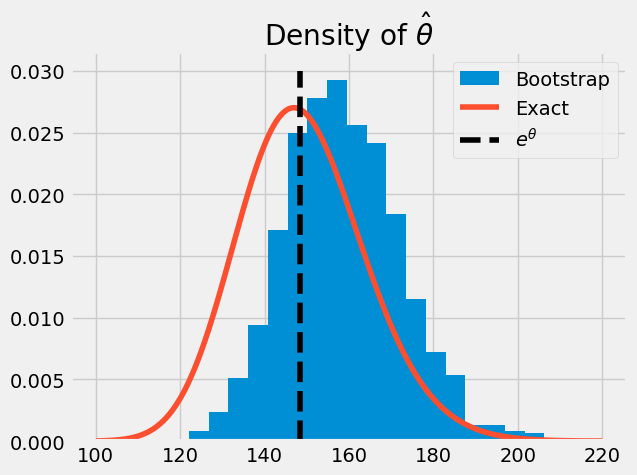

In [211]:
μ = 5.
n = 100

np.random.seed(1)
X = μ + np.random.randn(n)
func = lambda X: np.exp(X.mean())
stat = func(X)
bootstrap_stats = bootstrap(func=func, n_resamples=1_000, samples=X)

plt.hist(bootstrap_stats, bins=20, density=True, label="Bootstrap")
θ = np.linspace(100, 220, 1001)
y = np.sqrt(n) / θ * scipy.stats.norm.pdf(np.sqrt(n) * (np.log(θ) - μ))
plt.plot(θ, y, label="Exact")
plt.vlines(np.exp(μ), 0., 0.03, color="k", label=r"$e^\theta$", linestyle="--")
plt.legend()
plt.title(r"Density of $\hat{\theta}$")

make_ci_table(bootstrap_stats=bootstrap_stats, confidence=0.95, stat=stat)

## 7.

(a)

Recall from Chapter 6 Question 2 that the distribution of $\hat{\theta}$ is

$$
f_{\hat{\theta}}(y)=n\frac{y^{n-1}}{\theta^{n}}I_{(0,\theta)}(y).
$$

This is compared to histograms from the bootstrap below.

'<table>\n<thead>\n<tr><th>Interval type  </th><th style="text-align: right;">  Lower bound</th><th style="text-align: right;">  Upper bound</th></tr>\n</thead>\n<tbody>\n<tr><td>Normal         </td><td style="text-align: right;">     0.95093 </td><td style="text-align: right;">     1.02679 </td></tr>\n<tr><td>Pivotal        </td><td style="text-align: right;">     0.988861</td><td style="text-align: right;">     1.06913 </td></tr>\n<tr><td>Percentile     </td><td style="text-align: right;">     0.908596</td><td style="text-align: right;">     0.988861</td></tr>\n</tbody>\n</table>'

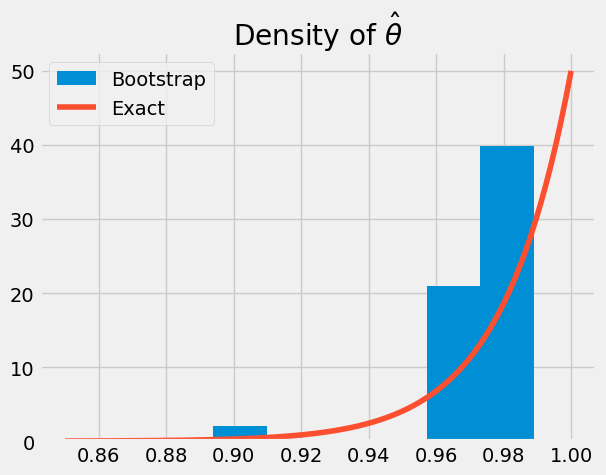

In [6]:
θ = 1.
n = 50

np.random.seed(1)
X = np.random.uniform(low=0., high=θ, size=(n, ))
func = lambda X: X.max()
stat = func(X)
bootstrap_stats = bootstrap(func=func, samples=X, n_resamples=1_000)

plt.hist(bootstrap_stats, bins=np.unique(bootstrap_stats).size, density=True, label="Bootstrap")
y = np.linspace(0.85, 1, 101)
f = n * y**(n - 1) / θ**n
plt.plot(y, f, label="Exact")
plt.legend()
plt.title(r"Density of $\hat{\theta}$")

make_ci_table(bootstrap_stats=bootstrap_stats, confidence=0.95, stat=stat)

(b) If the $X_{i}$ are distinct,

$$
\mathbb{P}( \hat{\theta}^* = \hat{\theta} \mid \vec{X} )
=1 - \mathbb{P}(\hat{\theta}^* < \hat{\theta} \mid \vec{X})
=1-\left(1-1/n\right)^{n}.
$$

Since

$$
\mathbb{P}(\hat{\theta}^{*}=\hat{\theta}\mid \vec{X})=\mathbb{E}[I_{\{\hat{\theta}^{*}=\hat{\theta}\}}\mid \vec{X}],
$$

by the tower property and the fact that $X_{i}=X_{j}$ occurs with probability zero whenever $i\neq j$, it follows that

$$
\mathbb{P}(\hat{\theta}^{*}=\hat{\theta})=1-\left(1-1/n\right)^{n}.
$$

This quantity converges to $1-1/e\approx0.632$ as $n$ gets large.

## 8.

See ["Bootstrap variance of squared sample mean"](https://stats.stackexchange.com/q/112131).